In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from os import PathLike
import os

from aind_vr_foraging_analysis.utils.parsing import parse, data_access
import aind_vr_foraging_analysis.utils.plotting as plotting

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'C:\Users\jason.lee\OneDrive - Allen Institute\Documents\patch_foraging'
base_path = r'\\allen\aind\scratch\vr-foraging\data'
foraging_figures = r'C:\Users\jason.lee\OneDrive - Allen Institute\Documents\patch_foraging'

In [2]:
# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif 'double' in text:
        return 'Do'
    else:
        return text

In [12]:
class MetricsVrForaging():
    def __init__(self, session_path: PathLike):
        self.session_path = session_path
        self.active_site, self.stream_data, self.data = data_access.load_session(
        session_path
        )
        
        self.reward_sites = self.active_site.loc[self.active_site['label'] == 'OdorSite']
        self.session = self.data['config'].streams.session_input.data['date'][:10]
        self.mouse = int(self.data['config'].streams.session_input.data['subject'])
        self.stage = self.data['config'].streams.tasklogic_input.data['stage_name']
        self.rig_name = self.data['config'].streams.rig_input.data['rig_name']
        self.experimenter = self.data['config'].streams.session_input.data['experimenter'][0]
        self.updaters = self.data['config'].streams.tasklogic_input.data['task_parameters']['updaters']

        # print(self.rig_name)
        # print(self.stage)
        # print(self.experimenter)
        
        if self.stage == 'thermistor screening':
            return
        
        self.df = self.retrieve_metrics()

    def retrieve_metrics(self) -> pd.DataFrame:
        reward_sites = self.reward_sites
        active_site = self.active_site
        data = self.data

        df = pd.DataFrame()
        # Summary of different relevants aspects -------------------------------------------------

        unrewarded_stops = reward_sites.loc[reward_sites.is_reward==0]['reward_amount'].count()
        rewarded_stops = reward_sites.loc[reward_sites.is_reward==1]['reward_amount'].count()
        water_collected = reward_sites.loc[(reward_sites['is_reward']==1)]['reward_amount'].sum()
        total_stops = reward_sites.loc[(reward_sites['is_choice']==True)]['reward_amount'].count()

        # print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
        #    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

        # print('Total travelled m: ', np.round(active_site.start_position.max()/100,2), ', current position (cm): ', data['operation_control'].streams.CurrentPosition.data.max()[0])

        for odor_label in reward_sites.odor_label.unique():
            values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['is_reward']==1)]['reward_amount'].sum()
            # print(f'{odor_label} {values} ul')
            
        df.at[0,'odor_sites_travelled'] = int(len(reward_sites))
        df.at[0,'distance_m'] = data['operation_control'].streams.CurrentPosition.data.max()[0]/100
        df.at[0,'water_collected_ul'] = water_collected
        df.at[0,'rewarded_stops'] = int(rewarded_stops)
        df.at[0,'total_stops'] = int(total_stops)
        df.at[0,'session_duration_min'] = (reward_sites.index[-1] - reward_sites.index[0])/60
        df.at[0, 'total_patches_visited'] = reward_sites.loc[reward_sites['site_number'] >= 1].patch_number.nunique()
        return df

    def retrieve_updater_values(self):
        # Initialize a pointer for the data values
        data_pointer = 0
        
        reward_sites = self.reward_sites
        data = self.data
        df = self.df
        
        # Helper function to safely extract stream data
        def get_stream_data(data, key):
            try:
                stream = data['updater_events'].streams[key].data['data']
                stream.reset_index(drop=True, inplace=True)
                return stream
            except (KeyError, AttributeError):
                return None

        # Load updater data safely
        stop_duration = get_stream_data(data, 'UpdaterStopDurationOffset')
        delay = get_stream_data(data, 'UpdaterRewardDelayOffset')
        velocity_threshold = get_stream_data(data, 'UpdaterStopVelocityThreshold')

        ## print(stop_duration)
        # Create new columns in reward_sites with default values
        reward_sites['delay_s'] = np.nan
        reward_sites['velocity_threshold_cms'] = np.nan
        reward_sites['stop_duration_s'] = np.nan

        data_pointer = 0
        try:
            for index, row in reward_sites.iterrows():
                if row['is_reward'] == 1:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
                    data_pointer += 1
                else:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
        except IndexError:
            if delay is not None:
                reward_sites.at[index, 'delay_s'] = delay.max()
            if velocity_threshold is not None:
                reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold.max()
            if stop_duration is not None:
                reward_sites.at[index, 'stop_duration_s'] = stop_duration.max()

        # Summary of the training metrics
        reward_sites['odor_sites'] = np.arange(1, len(reward_sites) + 1)

        # Safely update df only if values exist
        if delay is not None:
            df.at[0, 'start_delay'] = reward_sites['delay_s'].min()
            df.at[0, 'end_delay'] = reward_sites['delay_s'].max()
            df.at[0, 'sites_to_max_delay'] = reward_sites[reward_sites['delay_s'] == reward_sites['delay_s'].max()].iloc[0]['odor_sites']

        if stop_duration is not None:
            df.at[0, 'start_stop_duration'] = reward_sites['stop_duration_s'].min()
            df.at[0, 'end_stop_duration'] = reward_sites['stop_duration_s'].max()
            df.at[0, 'sites_to_max_stop_duration'] = reward_sites[reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()].iloc[0]['odor_sites']
            df.at[0, 'rewarded_sites_in_max_stop'] = int(reward_sites[(reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()) & (reward_sites.is_choice == 1)]['odor_sites'].nunique())

        if velocity_threshold is not None:
            df.at[0, 'start_velocity_threshold'] = reward_sites['velocity_threshold_cms'].min()
            df.at[0, 'end_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'target_max_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'sites_to_min_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].min()].iloc[0]['odor_sites']
            df.at[0, 'sites_to_max_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].max()].iloc[0]['odor_sites']        
        
        self.reward_sites = reward_sites
        self.df = df

    def get_metrics(self):
        return self.df

    def get_reward_sites(self):
        return self.reward_sites
    
    def get_mouse_and_session(self):
        return self.mouse, self.session
    
    def run_pdf_summary(self):
        color1='#d95f02'
        color2='#1b9e77'
        color3='#7570b3'
        color4='#e7298a'

        color_dict_label = {'InterSite': '#808080',
            'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02',
            'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
            'PatchB': '#d95f02','PatchA': '#7570b3', 
            'PatchC': '#1b9e77',
            'Alpha-pinene': '#1b9e77', 
            'Methyl Butyrate': '#7570b3', 
            'Amyl Acetate': '#d95f02', 
            'Fenchone': '#7570b3', 
            'Dipropyl sulfide': '#7570b3',
            'Hexanal': '#1b9e77',
            'Pentyl acetate': '#d95f02',
            'S': color1,
            'D': color2,
            'N': color3,   
            'Do': color1,
            'None': color4
            }
        
        odor_sites = self.reward_sites.copy()
        encoder_data = self.stream_data.encoder_data
        active_site = self.active_site.copy()
        
        active_site['mouse'] = self.mouse
        active_site['session'] = self.session
        
        # Apply function
        active_site['long_patch_label'] = active_site['patch_label']
        active_site['patch_label'] = active_site['patch_label'].apply(get_condition_code)
        
        # odor_sites['odor_label'] = odor_sites['odor_label'].str.replace(' ', '_')
        
        # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['patch_number'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['patch_number'].max()
            
        odor_sites['engaged'] = odor_sites['patch_number'] <= last_engaged_patch  
    
        try:
            odor_sites['block'] = odor_sites['patch_label'].str.extract(r'set(\d+)').astype(int)
        except ValueError: 
            odor_sites['block'] = 0

        # Apply function
        odor_sites['long_patch_label'] = odor_sites['patch_label']
        odor_sites['patch_label'] = odor_sites['patch_label'].apply(get_condition_code)
        
        trial_summary = plotting.trial_collection(odor_sites[['is_choice', 'site_number', 'odor_label', 'depleted', 'odor_sites', 'is_reward','reward_probability','reward_amount','reward_available']], 
                                                  encoder_data, 
                                                  window=(-1,3)
                                                )
    
        # Save each figure to a separate page in the PDF
        pdf_filename = f'{self.mouse}_{self.session}_summary.pdf'
        with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
            text1 = ('Mouse: ' + str(self.mouse) 
            + '\nSession: ' + str(self.session) 
            + '\nRig: ' + str(self.rig_name) 
            + '\nStage: ' + str(self.stage)
            + '\nTotal sites: '  + str(self.df.total_stops.iloc[0]) 
            + '\nTotal rewarded stops: ' + str(self.df.rewarded_stops.iloc[0]) + ' (' +str(np.round((self.df.rewarded_stops.iloc[0]/self.df.total_stops.iloc[0])*100,2)) + '%) \n' 
            + 'Water consumed: ' +  str(np.round(self.df.water_collected_ul.iloc[0], 2)) + 'ul\n' 
            + 'Session duration: ' + str(np.round(self.df.session_duration_min.iloc[0],2)) + 'min\n' 
            + 'Total travelled m: ' + str(np.round(active_site.start_position.max()/100,2))
            )
            
            # '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            text_to_figure = text1
            # if self.stage[:7] == 'shaping':
            #     text2 = '\nTotal sites travelled: ' + str(self.df.odor_sites_travelled.iloc[0]) + '\nRewarded stops in max stop duration: ' + str(self.df.rewarded_sites_in_max_stop.iloc[0]) + '\nTotal patches visited: ' + str(self.df.total_patches_visited.iloc[0])
            #     text_to_figure = text1 + text2
            
            # Create a figure
            fig, ax = plt.subplots(figsize=(8.5, 11))  # Standard letter size
            ax.text(0.1, 0.9, text_to_figure, ha='left', va='center', fontsize=12)
            ax.axis('off')  # Hide the axes
            pdf.savefig(fig)
            plt.close(fig)
            
            # plotting.raster_with_velocity(active_site, stream_data, color_dict_label=color_dict_label, save=pdf)
            plotting.segmented_raster_vertical(odor_sites, 
                                            save=False, 
                                            color_dict_label=color_dict_label)
            plotting.raster_with_velocity(active_site, self.stream_data, color_dict_label=color_dict_label, save=pdf)
        
            plotting.summary_withinsession_values(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            plotting.speed_traces_efficient(trial_summary, self.mouse, self.session,  save=pdf)
            plotting.preward_estimates(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            plotting.speed_traces_value(trial_summary, self.mouse, self.session, condition = 'reward_probability', save=pdf) 
            plotting.velocity_traces_odor_entry(trial_summary, max_range = trial_summary.speed.max(), color_dict_label=color_dict_label, save=pdf)

            plotting.length_distributions(self.active_site, self.data, delay=True, save=pdf)
            if len(self.updaters):
                plotting.update_values(self.reward_sites, save=pdf)
            
        return pdf_filename

### **Do it for several animals**

In [4]:
trainer_dict = {'745305': 'Olivia', 
                '745302': 'Olivia', 
                '754570': 'Olivia', 
                '754571': 'Olivia', 
                '754572' : 'Olivia', 
                '754582': 'Olivia',
                '745300': 'Olivia',
                '745301': 'Huy',
                '754575': 'Huy',
                '754573': 'Huy',
                '754567': 'Huy',
                '754579': 'Huy',
                '745306': 'Huy',
                '745307': 'Huy',
                '754580': 'Katrina',
                '754560': 'Katrina',
                '754559': 'Katrina',
                '754574': 'Katrina',
                '754577': 'Katrina',
                '754566': 'Katrina',
}               

# stage_progression = {'stageA_v1': 'Stage A',

In [4]:
trainer_dict = {
                '789911': 'Huy',
                '788641': 'Huy',
                '781896': 'Jason',
                '781898': 'Jason',
}      

In [5]:
# mouse_list = trainer_dict.keys()
mouse_list = ["781896","781898", "788641"]
date_string = "2025-6-02"

In [14]:
import re

all_dfs = []

# mouse_list = trainer_dict.keys()
mouse_list = ["781896","781898", "788641"]
date_string = "2025-6-02"

for mouse in mouse_list:
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='on_or_after'
    )

    for session_path in session_paths:
        print(mouse)
        parsed_session = MetricsVrForaging(session_path)
        if parsed_session.stage == 'thermistor screening':
            continue
        
        df = parsed_session.get_metrics()
        df['trainer'] = trainer_dict[mouse]
        df['session'] = parsed_session.session
        df['stage'] = parsed_session.stage
        df['rig'] = parsed_session.rig_name
        df['mouse'] = mouse 
        
        try:
            simplified_stage = re.search(r'stage([A-Za-z])', parsed_session.stage).group(1)
        except:
            simplified_stage = parsed_session.stage
            
        df['simplified_stage'] = simplified_stage

        all_dfs.append(df)

super_df = pd.concat(all_dfs, ignore_index=True)

781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781896
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
781898
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641
788641


In [15]:
super_df.to_csv("DF_to_VR_metrics_250711.csv", index=False)

In [29]:
df = pd.read_csv("DF_to_VR_metrics_250711.csv")

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

focus = 'rewarded_stops'

def plot_metrics_across_sessions(df, focus):
    df['session'] = pd.to_datetime(df['session'])

    # Extract stage letter if present (NaN for 'data_collection')
    df['stage_letter'] = df['stage'].str.extract(r'stage([A-Z])')

    # Sort and assign session index
    df = df.sort_values(by=['mouse', 'session'])
    df['session_index'] = df.groupby('mouse').cumcount()

    plt.figure(figsize=(16,7))

    for mouse, mouse_df in df.groupby('mouse'):
        plt.plot(mouse_df['session_index'], mouse_df[focus], marker='o', label=f'Mouse {mouse}')
        
        # First Stage B session
        stage_b_row = mouse_df[mouse_df['stage_letter'] == 'B'].head(1)
        if not stage_b_row.empty:
            plt.scatter(stage_b_row['session_index'], stage_b_row[focus], 
                        color='yellow', s=80, zorder=5, label=f'{mouse} stage B')

        # First Stage C session
        stage_c_row = mouse_df[mouse_df['stage_letter'] == 'C'].head(1)
        if not stage_c_row.empty:
            plt.scatter(stage_c_row['session_index'], stage_c_row[focus], 
                        color='red', s=80, zorder=5, label=f'{mouse} stage C')

        # First data_collection after stage C
        after_stage_c = False
        for _, row in mouse_df.iterrows():
            if row['stage_letter'] == 'C':
                after_stage_c = True
            if 'data_collection' in row['stage'] and after_stage_c:
                plt.scatter(row['session_index'], row[focus],
                            color='black', s=80, marker='*', zorder=5, label=f'{mouse} data_collection')


    plt.xlabel('Session number')
    plt.ylabel(focus)
    plt.title(focus + ' across sessions per mouse')
    plt.grid(True)

    plt.xlim(0,25.5)

    from matplotlib.lines import Line2D

    mouse_lines = []
    for mouse, color in zip(df['mouse'].unique(), ['tab:blue', 'tab:orange', 'tab:green']):
        mouse_lines.append(Line2D([0], [0], color=color, lw=2, label=f'Mouse {mouse}'))

    stage_markers = [
        Line2D([0], [0], marker='o', color='w', label='Stage B', markerfacecolor='yellow', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Stage C', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='*', color='w', label='Data Collection', markerfacecolor='black', markersize=10)
    ]

    legend_elements = mouse_lines + stage_markers

    plt.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        borderaxespad=0.5
    )
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()


In [31]:
df[df['mouse'] == 781898]

,odor_sites_travelled,distance_m,water_collected_ul,rewarded_stops,total_stops,session_duration_min,total_patches_visited,trainer,session,stage,rig,mouse,simplified_stage
26,266.0,149.359199,980.0,196.0,199.0,60.792917,18.0,Jason,2025-06-02,shaping_stageA_distanceA_stopA_probA,4B,781898,A
27,536.0,685.898047,1150.0,230.0,259.0,60.268267,35.0,Jason,2025-06-03,shaping_stageA_distanceB_stopB_probB,4B,781898,A
28,381.0,975.670938,870.0,174.0,191.0,62.239200,6.0,Jason,2025-06-04,shaping_stageA_distanceD_stopC_probB,4B,781898,A
29,359.0,854.446953,885.0,177.0,191.0,60.957867,26.0,Jason,2025-06-05,shaping_stageA_distanceD_stopD_probB,4B,781898,A
30,455.0,719.607656,1125.0,225.0,360.0,59.670700,17.0,Jason,2025-06-06,shaping_stageB_distanceD_stopD_probB,4B,781898,B
31,405.0,911.190938,835.0,167.0,233.0,60.279900,40.0,Jason,2025-06-09,shaping_stageB_distanceD_stopE_probB,4B,781898,B
32,391.0,861.674219,840.0,168.0,238.0,60.242434,42.0,Jason,2025-06-10,shaping_stageB_distanceD_stopE_probB,4B,781898,B
33,422.0,1038.963440,835.0,167.0,219.0,60.236667,37.0,Jason,2025-06-11,shaping_stageB_distanceD_stopE_probB,4B,781898,B
34,412.0,1100.790940,710.0,142.0,186.0,59.861533,27.0,Jason,2025-06-12,shaping_stageB_distanceD_stopE_probB,4B,781898,B
35,250.0,1026.596330,35.0,7.0,9.0,59.623867,8.0,Jason,2025-06-13,shaping_stageC_distanceD_stopE_probB,4B,781898,C


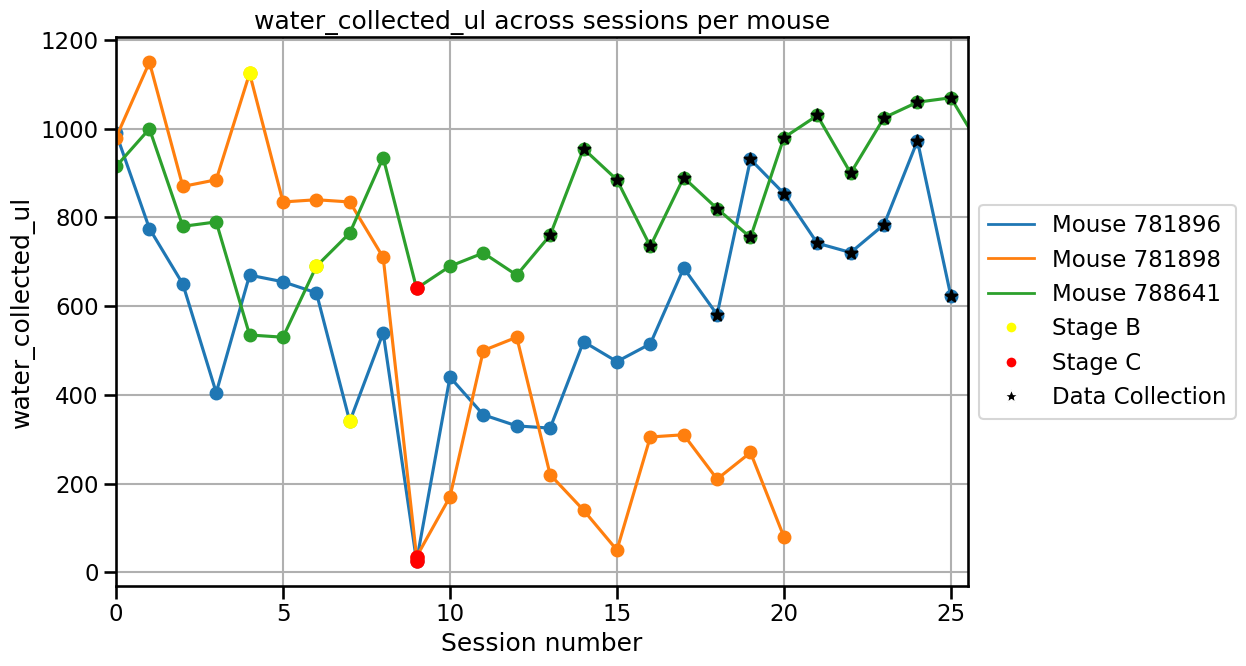

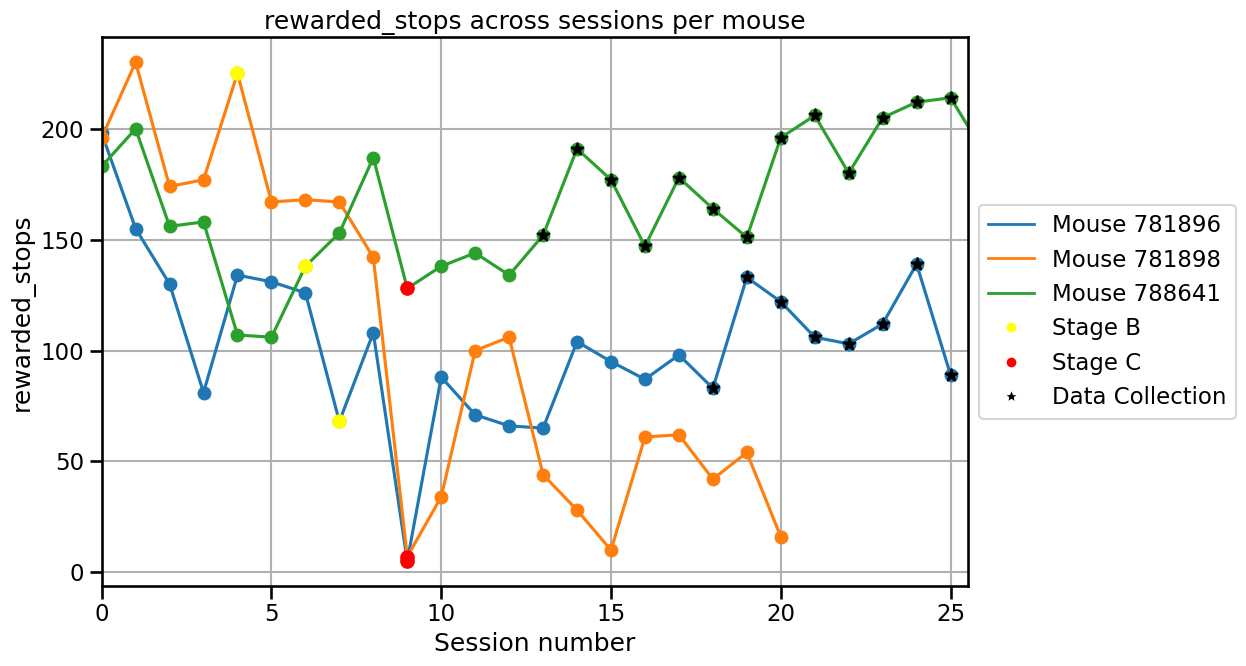

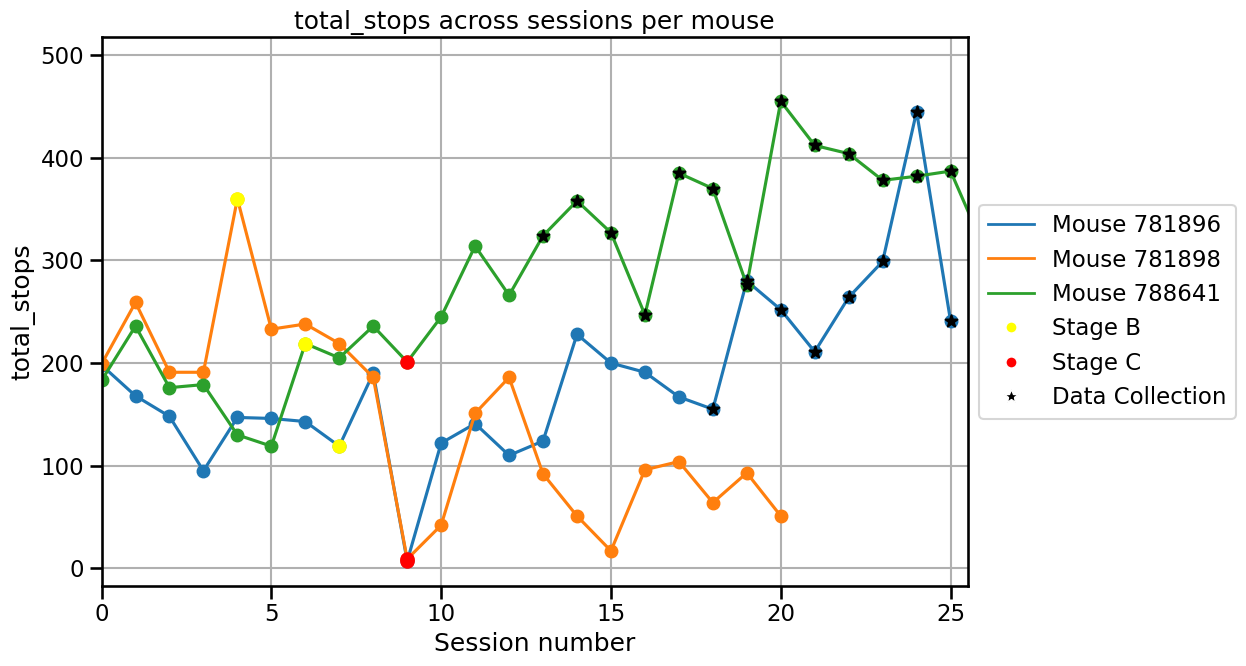

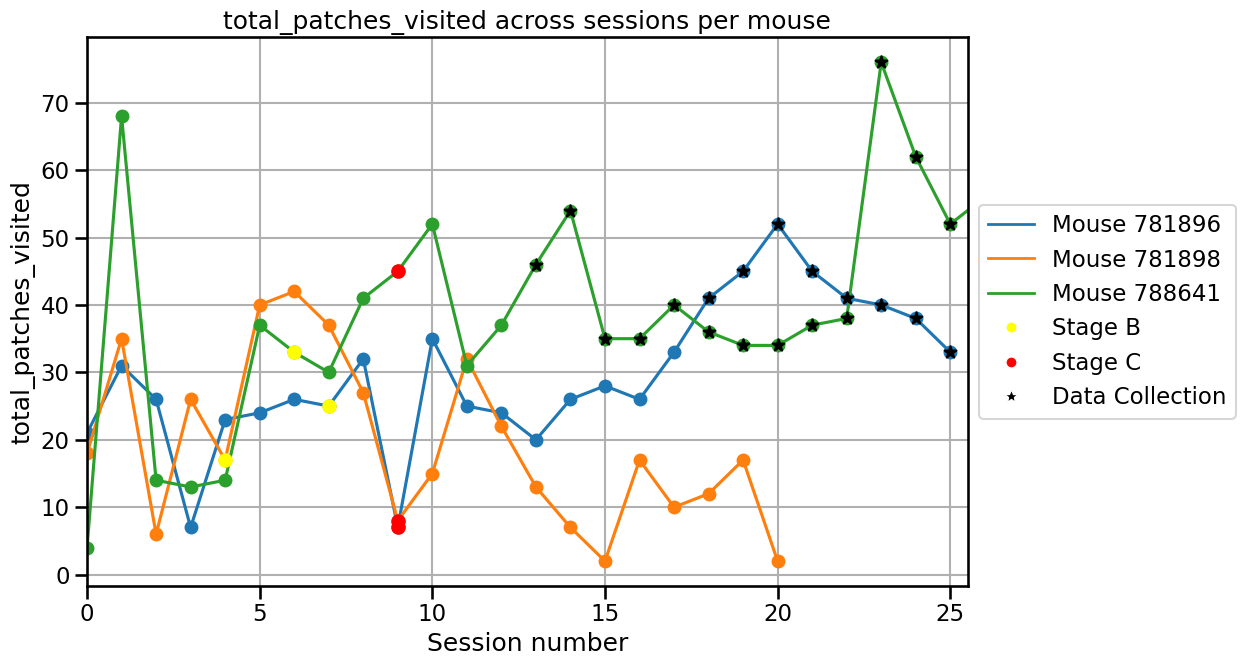

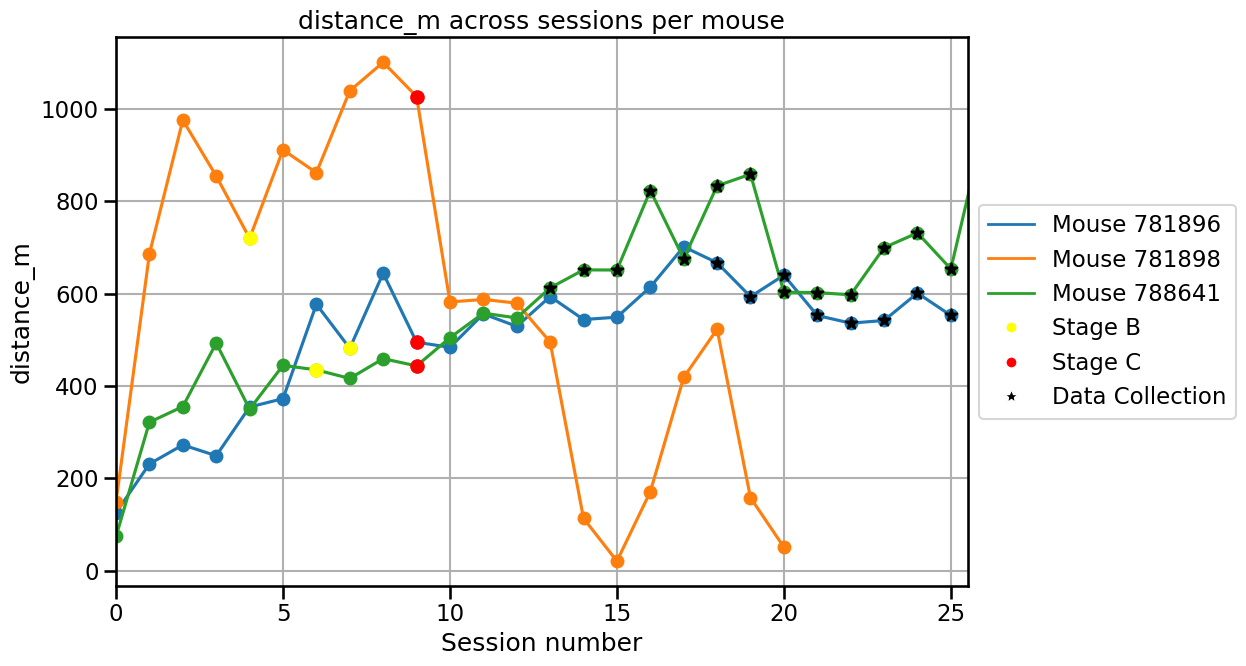

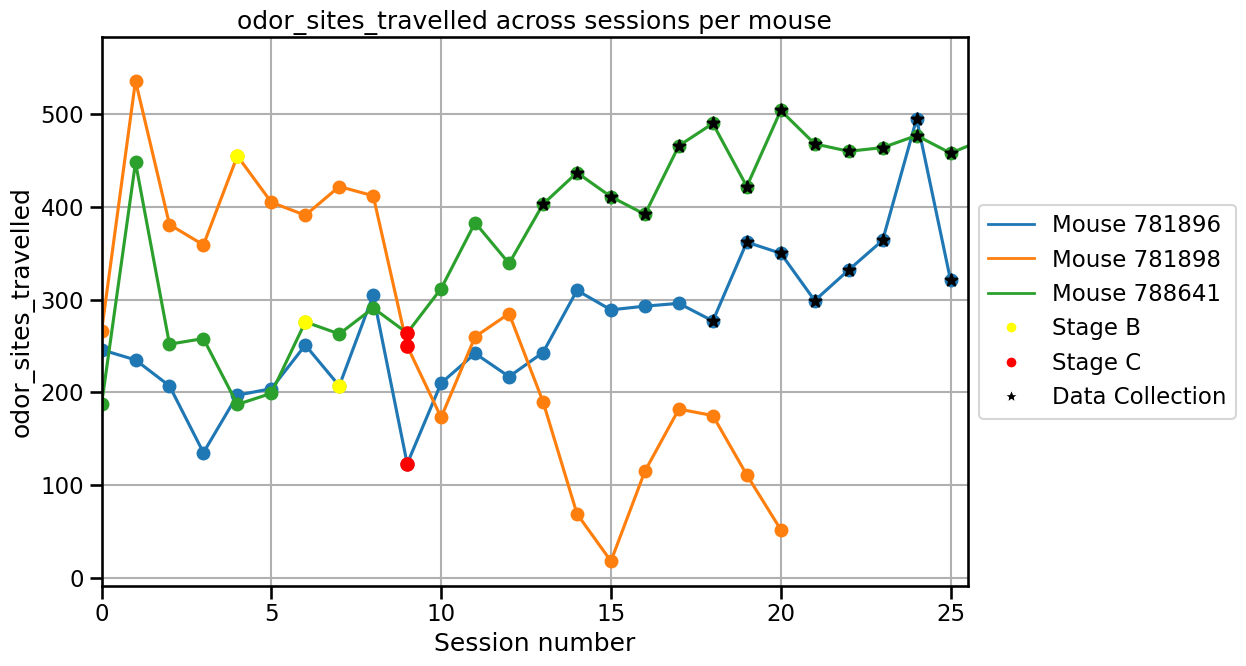

In [24]:
plot_metrics_across_sessions(df, 'water_collected_ul')
plot_metrics_across_sessions(df, 'rewarded_stops')
plot_metrics_across_sessions(df, 'total_stops')
plot_metrics_across_sessions(df, 'total_patches_visited')
plot_metrics_across_sessions(df, 'distance_m')
plot_metrics_across_sessions(df, 'odor_sites_travelled')

In [ ]:
# mouse_list = trainer_dict.keys()
mouse_list = ["781896"]
date_string = "2025-7-01"

for mouse in mouse_list:
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='on'
    )

    for session_path in session_paths:
        print(mouse)
        parsed_session = MetricsVrForaging(session_path)
        if parsed_session.stage == 'thermistor screening':
            continue
        
        df = parsed_session.get_metrics()
        df['trainer'] = trainer_dict[mouse]
        df['session'] = parsed_session.session
        df['stage'] = parsed_session.stage
        df['rig'] = parsed_session.rig_name
        df['mouse'] = mouse 
        
        try:
            simplified_stage = re.search(r'stage([A-Za-z])', parsed_session.stage).group(1)
        except:
            simplified_stage = parsed_session.stage
            
        df['simplified_stage'] = simplified_stage


781896
data_collection_7
Total sites:  299  |  Total rewarded stops:  106 ( 50.24 %) |  Total unrewarded stops:  193 ( 91.47 %) |  Water consumed:  742.0 ul
Total travelled m:  551.51 , current position (cm):  55251.2188
Pentyl acetate 406.0 ul
Hexanal 336.0 ul
Dipropyl sulfide 0.0 ul


In [10]:
parsed_session.get_reward_sites().columns

Index(['label', 'start_position', 'length', 'friction', 'patch_number',
       'patch_label', 'odor_label', 'site_number', 'stop_time',
       'choice_cue_time', 'reward_onset_time', 'succesful_wait_time',
       'is_choice', 'is_reward', 'reward_amount', 'reward_probability',
       'reward_available', 'odor_sites', 'collected', 'depleted', 'last_visit',
       'last_site', 'cumulative_rewards', 'consecutive_rewards',
       'cumulative_failures', 'consecutive_failures',
       'after_choice_cumulative_rewards', 'duration_epoch', 'patch_onset',
       'time_since_entry', 'exit_epoch', 'skipped_count'],
      dtype='object')

In [ ]:
dp = parsed_session.get_reward_sites()
dp[['patch_number', 'site_number', 'patch_label', 'reward_probability', 'is_choice', 'is_reward', 'last_site']].head(50)

In [ ]:
dp[dp['last_site'] == True][['reward_probability', 'patch_label']]

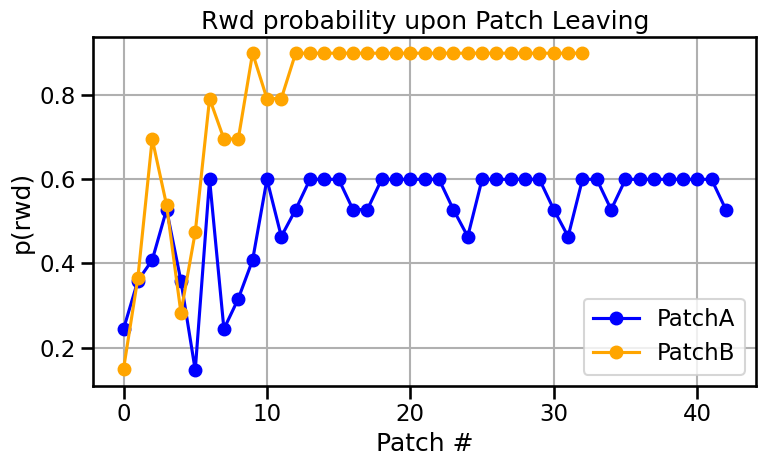

In [ ]:
import matplotlib.pyplot as plt

# Filter just the rows where last_site == True
patch_dp = dp[dp['last_site'] == True][['reward_probability', 'patch_label']]

# Add a visit index per patch label
patch_dp = patch_dp.copy()  # avoid SettingWithCopyWarning
patch_dp['visit'] = patch_dp.groupby('patch_label').cumcount()

# Plot
plt.figure(figsize=(8, 5))

for patch_label, color in zip(['PatchA', 'PatchB'], ['blue', 'orange']):
    subset = patch_dp[patch_dp['patch_label'] == patch_label]
    plt.plot(subset['visit'], subset['reward_probability'], marker='o', label=patch_label, color=color)

plt.xlabel("Patch #")
plt.ylabel("p(rwd)")
plt.title("Rwd probability upon Patch Leaving")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


['781896', '2025-07-07', 'data_collection_7']


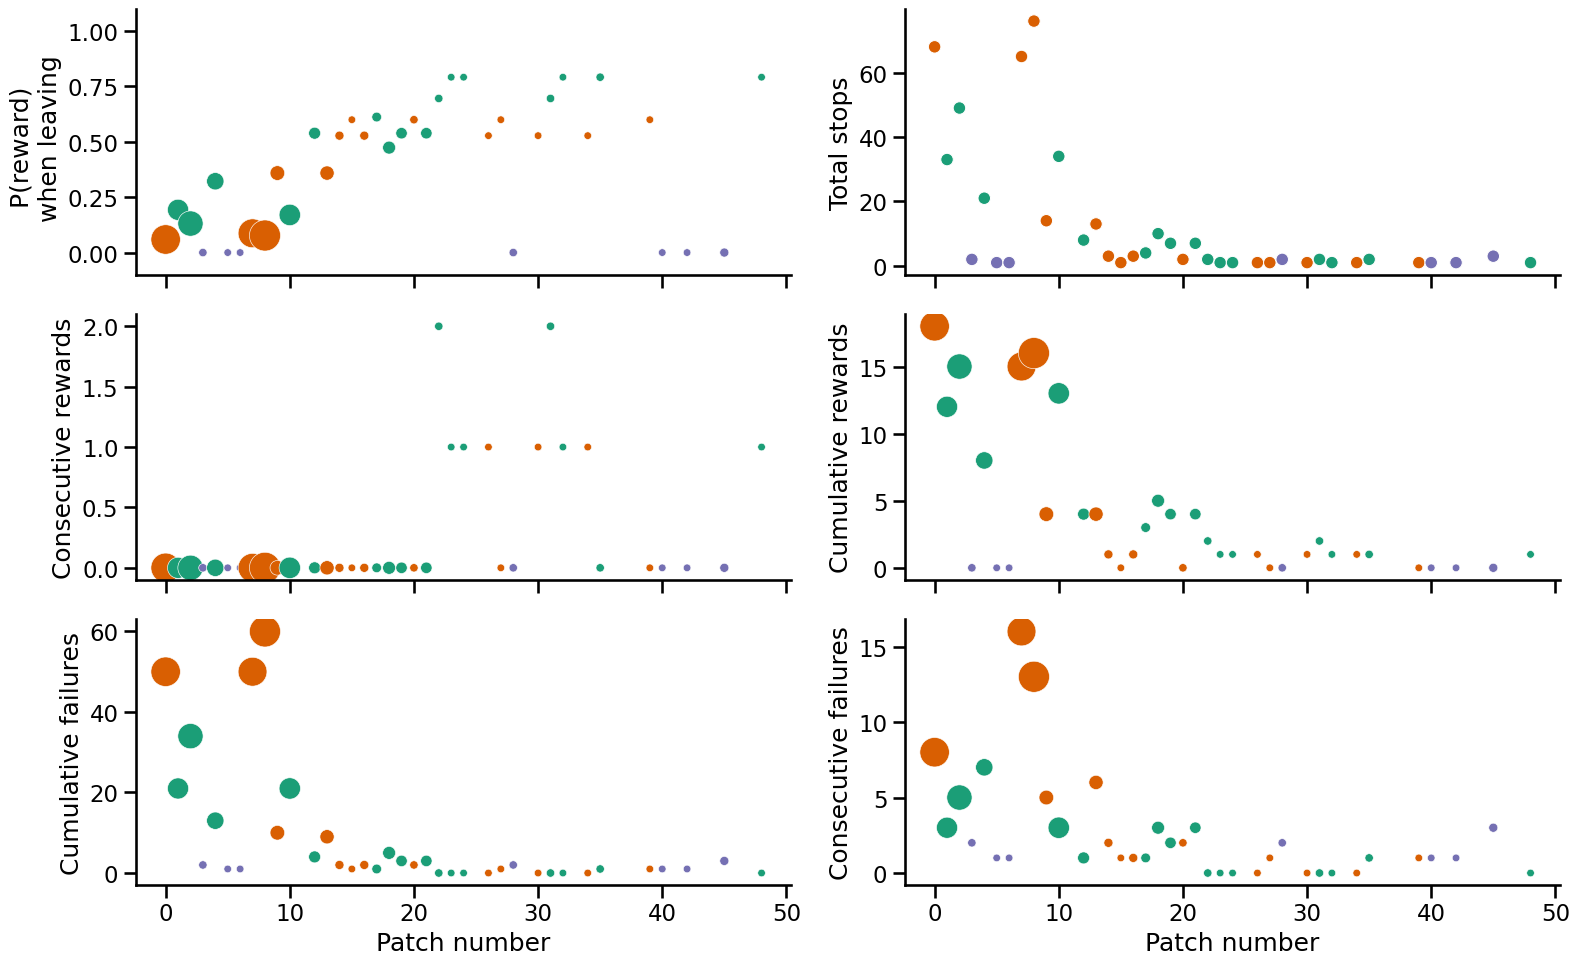

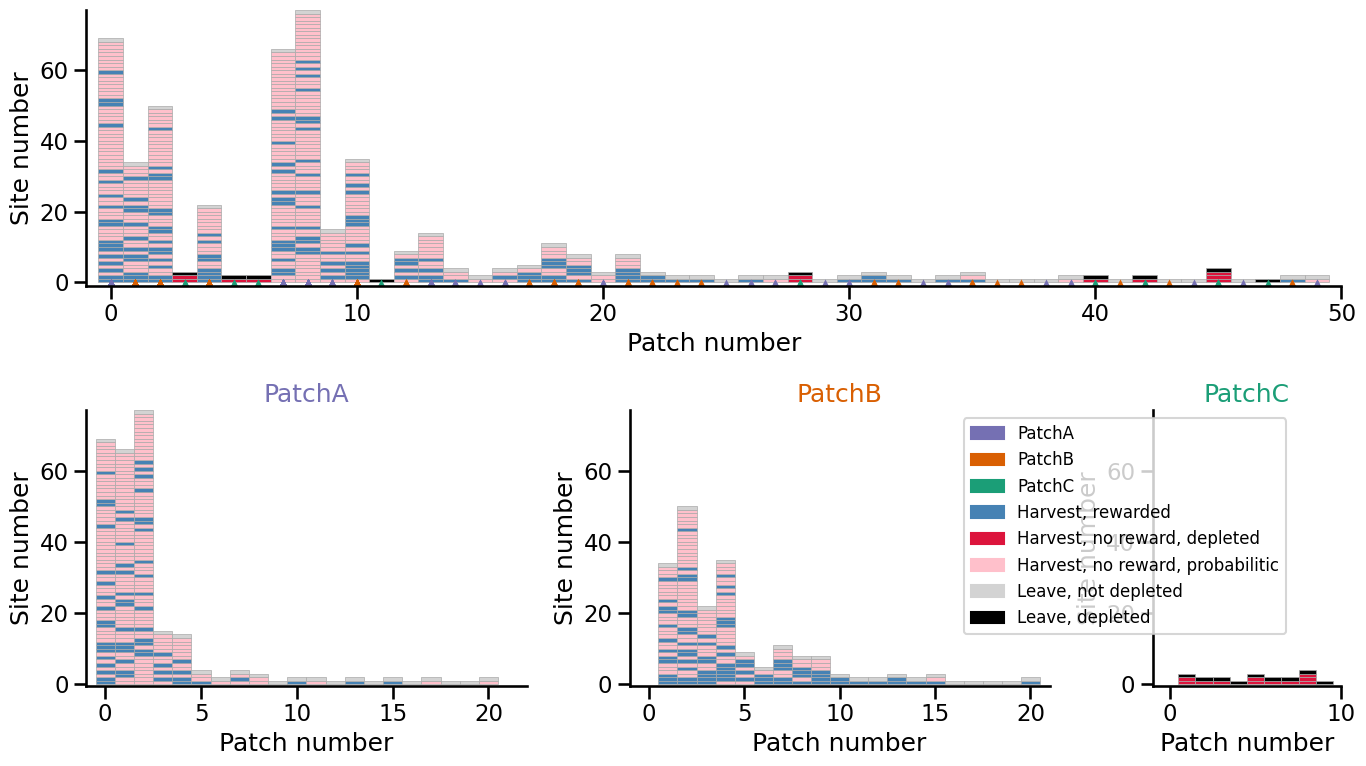

No sessions found for mouse 781898 with condition 'between' on 2025-7-05 to 2025-7-07
['788641', '2025-07-05', 'data_collection']


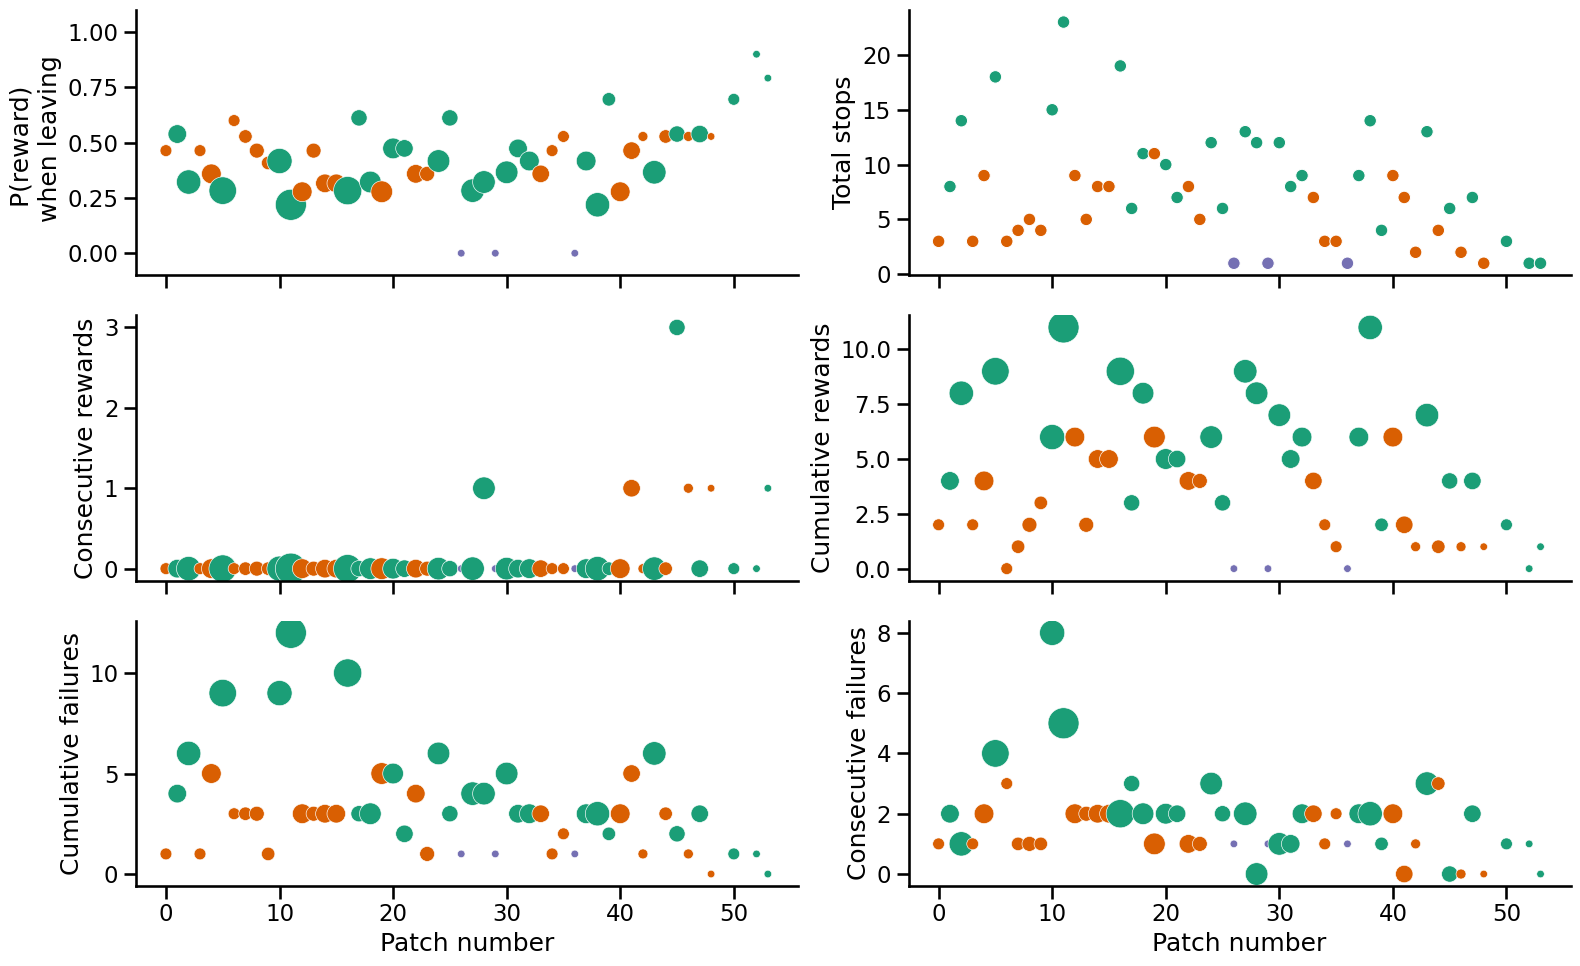

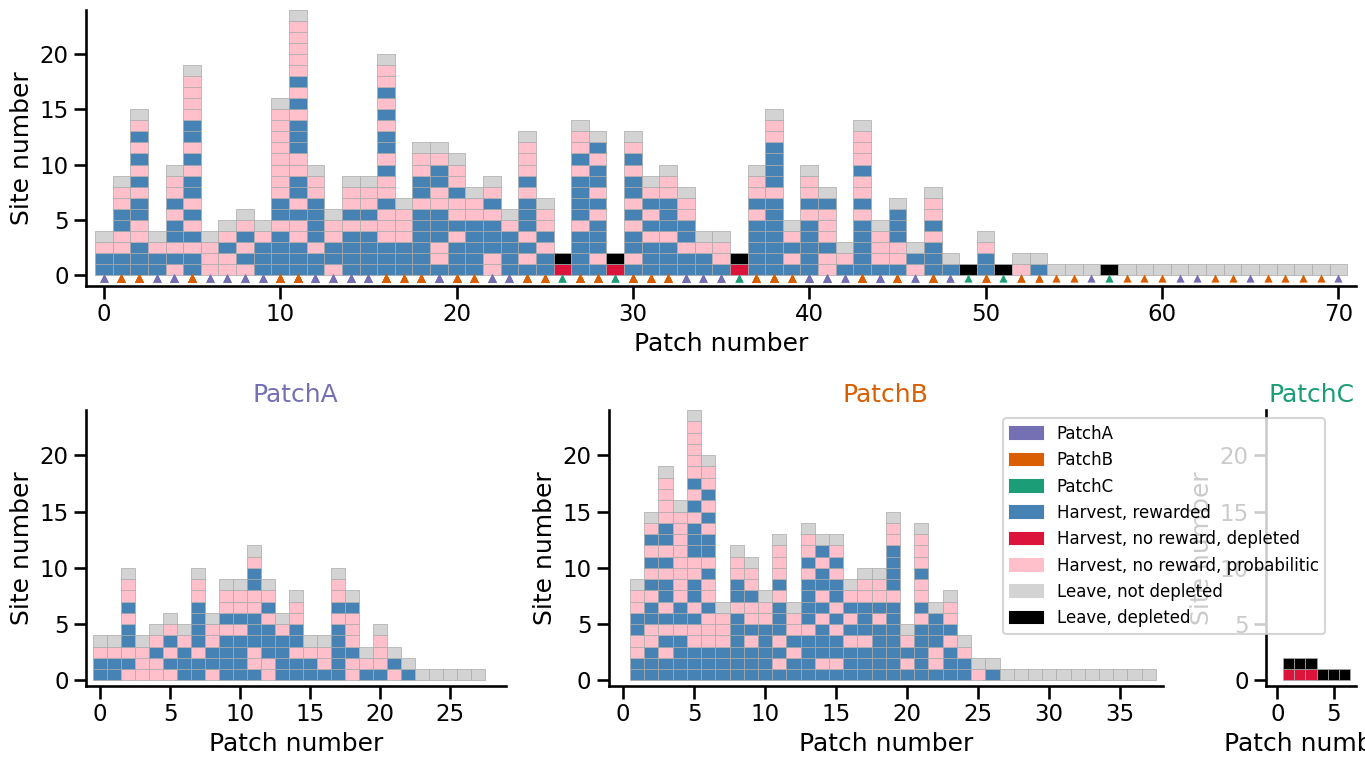

['788641', '2025-07-07', 'data_collection']


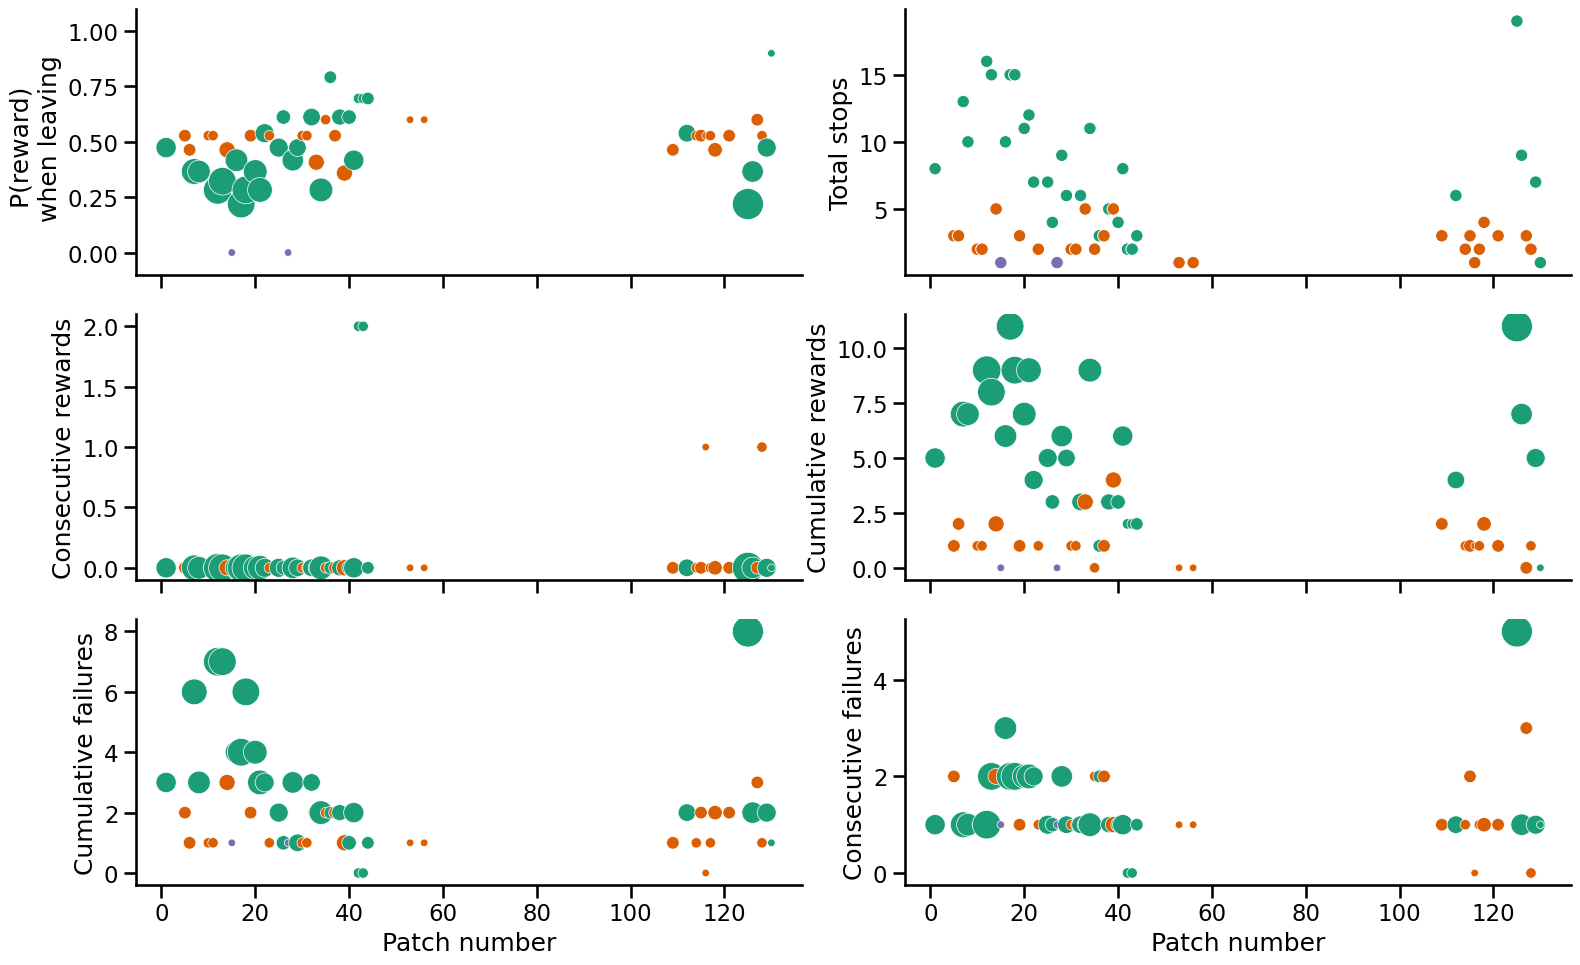

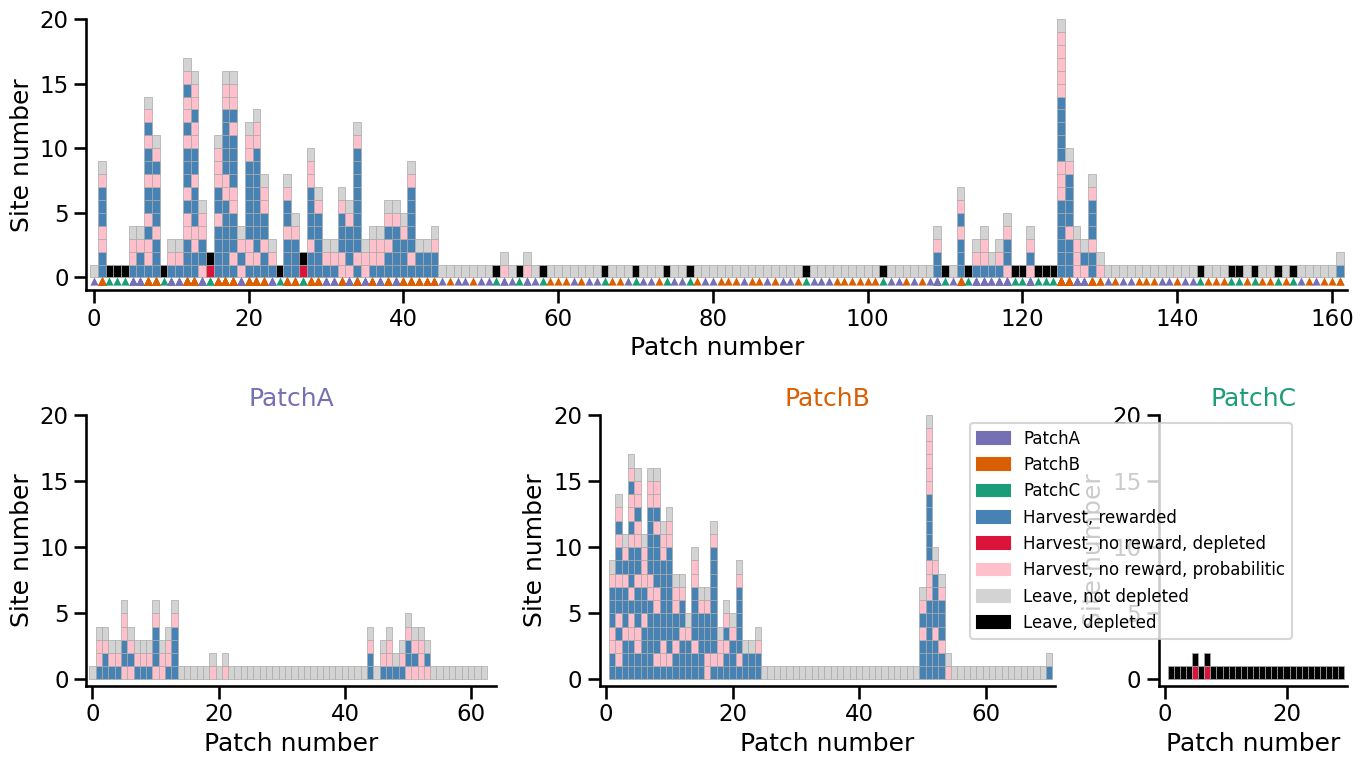

In [26]:
import re

mouse_list = ["781896","781898", "788641"]
date_string = "2025-7-05"

odor_sites_sum = pd.DataFrame()
for mouse in mouse_list:
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='between',
        end_date_string = "2025-7-07"
    )
    for session_path in session_paths:
        parsed_session = MetricsVrForaging(session_path)
        if parsed_session.stage == 'thermistor screening':
            continue
        
        df = parsed_session.get_metrics()
        df['trainer'] = trainer_dict[mouse]
        df['session'] = parsed_session.session
        df['stage'] = parsed_session.stage
        df['rig'] = parsed_session.rig_name
        df['mouse'] = mouse 

        print([mouse, parsed_session.session, parsed_session.stage])

        try:
            simplified_stage = re.search(r'stage([A-Za-z])', parsed_session.stage).group(1)
        except:
            simplified_stage = parsed_session.stage
            
        df['simplified_stage'] = simplified_stage
        
        reward_sites = parsed_session.get_reward_sites()

        if len(parsed_session.updaters) != 0:
            parsed_session.retrieve_updater_values()
        
        reward_sites['mouse'] = mouse
        reward_sites['session'] = parsed_session.session
        reward_sites['stage'] = parsed_session.stage
        reward_sites['simplified_stage'] = simplified_stage
        odor_sites_sum = pd.concat([odor_sites_sum, reward_sites], axis=0)

        color1='#d95f02'
        color2='#1b9e77'
        color3='#7570b3'
        color4='#e7298a'

        color_dict_label = {'InterSite': '#808080',
            'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02',
            'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
            'PatchB': '#d95f02','PatchA': '#7570b3', 
            'PatchC': '#1b9e77',
            'Alpha-pinene': '#1b9e77', 
            'Methyl Butyrate': '#7570b3', 
            'Amyl Acetate': '#d95f02', 
            'Fenchone': '#7570b3', 
            'Dipropyl sulfide': '#7570b3',
            'Hexanal': '#1b9e77',
            'Pentyl acetate': '#d95f02',
            'S': color1,
            'D': color2,
            'N': color3,   
            'Do': color1,
            'None': color4
            }
        
        odor_sites = parsed_session.reward_sites.copy()
                # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['patch_number'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['patch_number'].max()
            
        odor_sites['engaged'] = odor_sites['patch_number'] <= last_engaged_patch  
    
        try:
            odor_sites['block'] = odor_sites['patch_label'].str.extract(r'set(\d+)').astype(int)
        except ValueError: 
            odor_sites['block'] = 0

        plotting.summary_withinsession_values(odor_sites, color_dict_label = color_dict_label)   
        plotting.segmented_raster_vertical(odor_sites, save=False, color_dict_label=color_dict_label)